In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import cvxopt as opt

import importlib

import itertools

import markowitz_optimization

import sys
import os
print(os.getcwd())

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import stock_filter
importlib.reload(markowitz_optimization)
importlib.reload(stock_filter)

c:\Users\User\Desktop\Github-local\GFWM\gfwm-app\data_science\quant


<module 'stock_filter' from 'c:\\Users\\User\\Desktop\\Github-local\\GFWM\\gfwm-app\\data_science\\stock_filter.py'>

In [125]:

all_performance_summaries = pd.read_csv("sp500_performance_summaries.csv")
#print(all_performance_summaries.head())

adjusted_cov_matrix = pd.read_csv("sp500_adjusted_cov_matrix.csv")
adjusted_cov_matrix.set_index('ticker', inplace=True)

raw_cov_matrix = pd.read_csv("sp500_raw_cov_matrix.csv")
raw_cov_matrix.set_index('ticker', inplace=True)

#read benchmarks:
#source: https://ycharts.com/indices/^SPX, https://www.msci.com/indexes/index/700719

benchmarks_df = pd.read_csv('benchmarks.csv')

# Convert to a dictionary to easily access by key
benchmarks = dict(zip(benchmarks_df['key'], benchmarks_df['value']))

# Assign constants to variables
SP500_annual_return = benchmarks.get("SP500_annual_return")
SP500_annual_volatility = benchmarks.get("SP500_annual_volatility")

SPESG_annual_return = benchmarks.get("SPESG_annual_return")
SPESG_annual_volatility = benchmarks.get("SPESG_annual_volatility")

In [126]:

unique_tickers = pd.Series(all_performance_summaries.columns[1:].values)
#print(unique_tickers)

n=150
tickers = unique_tickers.sample(frac=(n+5)/500, random_state=12).reset_index(drop=True)

# keep selected tickers

# keep entries where both tickers are present
cov_matrix = adjusted_cov_matrix.loc[tickers, tickers].to_numpy()
true_cov_matrix = raw_cov_matrix.loc[tickers, tickers].to_numpy()

#convert to daily mean log returns
mean_log_returns = (all_performance_summaries[tickers].iloc[0])/252
#print(mean_log_returns * 252)

mu_bar = np.mean(mean_log_returns)
mu_sd = np.std(mean_log_returns)

# risk free rate based of historical average of 30d yield
annual_risk_free_rate = 0.0153

# daily target returns. scale to annual for graphing
# start at daily risk free rate
target_returns = np.linspace(start=pow(annual_risk_free_rate+1, 1/365.0) - 1, stop=0.2/252, num=50)

#TODO picking bounds: few different scenarios compared to equal weights

In [127]:
# generate portfolios
montecarlo_portfolios = markowitz_optimization.montecarlo_random_portfolios(mean_log_returns, 
                                                                            cov_matrix, 
                                                                            [0.0, 5.0/n], 
                                                                            iterations=1e5)

sp_optimal_portfolios, sp_best_fit = markowitz_optimization.calculate_optimal_portfolios(true_mean_returns=mean_log_returns,
                                                                                         adjusted_mean_returns=mean_log_returns,
                                                                                         true_cov= true_cov_matrix,
                                                                                         adjusted_cov=cov_matrix,
                                                                                         target_returns=target_returns,
                                                                                         annual_risk_free_rate=annual_risk_free_rate,
                                                                                         bounds = [0.333/n, 3.0/n],
                                                                                         calculate_best_fit=True)

In [128]:
print(target_returns.shape)
print(sp_optimal_portfolios.shape)

(50,)
(35, 5)


target_return                                                 0.000748
annual_return                                                 0.188397
annual_volatility                                             0.186571
weights              [0.002221265902701724, 0.002220776975694865, 0...
diversification                                               0.988543
Name: 45, dtype: object
[0.22204183358022522, 0.22205987028051802, 0.22206206289612893, 0.2220707499319084, 0.222072419985056, 0.2220769883167333, 0.2220776975694865, 0.22207891576583685, 0.2220805614530062, 0.2220808150951374, 0.22208350220378367, 0.22208361135530869, 0.22208481718983436, 0.2220863993542083, 0.22208780884416437, 0.2220903035524036, 0.2220911564007181, 0.22209248919925023, 0.2220929059819237, 0.2220963869758061, 0.22209814783054393, 0.22209908414619023, 0.22210207891447353, 0.22210516383272785, 0.22210623141735922, 0.2221063277415501, 0.22210878298240766, 0.2221120905195214, 0.2221122639496323, 0.22212047608682522, 0.222

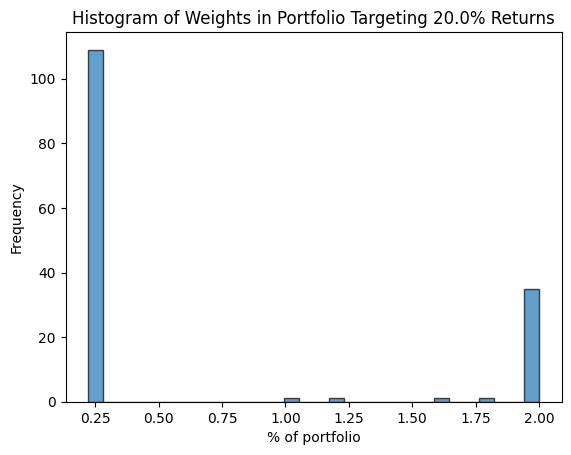

In [129]:
#find the portfolio nearest a given target return

sp_optimal_portfolios_sorted = sp_optimal_portfolios.sort_values(by='annual_return', ascending= True)
target_return = 0.2
closest_portfolio = sp_optimal_portfolios_sorted.loc[(sp_optimal_portfolios_sorted['annual_return'] - target_return).abs().idxmin()]
closest_portfolio_weights = closest_portfolio['weights'] * 100

print(closest_portfolio)

print(sorted(closest_portfolio_weights))

print(sum(closest_portfolio_weights))

plt.hist(closest_portfolio_weights, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('% of portfolio')
plt.ylabel('Frequency')
plt.title(f'Histogram of Weights in Portfolio Targeting {target_return * 100}% Returns')
plt.show()

In [130]:
def tangent_portfolio(returns, volatilities, return_best_fit = False):
    
    # Calculate quadratic best fit
    # annual_return as independent variable, annual_volatility as dependent variable
    best_fit = np.polynomial.Polynomial.fit(returns, 
                                            volatilities, 
                                            2, domain=[0.0, 0.5])


    #calculate tangent line to best fit curve, passing through (0, annual_rfr)
    # vol = ar^2 + br + c
    # derivative: 2ar + b

    # point slope form of line also passing through (vol_t, ret_t)
    # vol - vol_t = slope * (ret - ret_t)

    # at the tangency point (vol_t, ret_t), slopes are equal:
    # vol_t / (ret_t - rfr) = 2a * ret_t + b
    # solve for ret_t to find the tangency point (ret_t, vol_t)

    # best_fit(ret_t) / (ret_t - rfr) = 2a * ret_t + b
    # ar^2 + br + c = (r-rfr)(2ar+b)
    #               = 2a r^2 + (b-2arfr) * r - rfr*b
    # 0 = ar^2 - 2arfr * r - c - rfr*b

    [c, b, a] = best_fit.convert().coef
    tangency_poly = np.polynomial.Polynomial([-c - b * annual_risk_free_rate, 
                                            -2*a* annual_risk_free_rate,
                                            a])
    #find root in the acceptable range
    ret_t = [root for root in tangency_poly.roots() if 0 <= root <= 0.5][0]
    vol_t = best_fit(ret_t)
    
    if(return_best_fit):
        return (ret_t, vol_t, best_fit)
    else:
        return (ret_t, vol_t)

def tangent_line(r, ret_t, vol_t):
    slope = vol_t / (ret_t - annual_risk_free_rate)
    return vol_t + (slope * (r-ret_t))

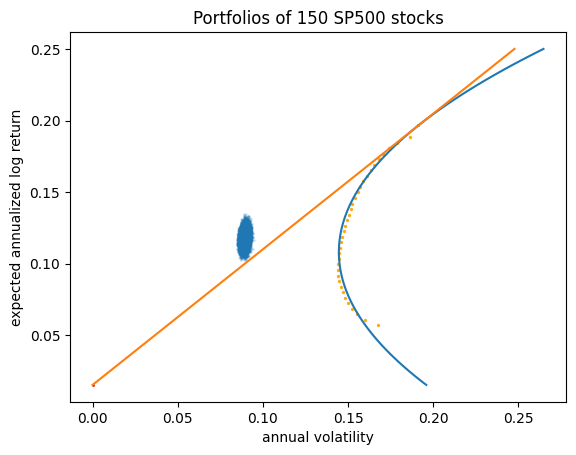

In [131]:
fig1 = plt.figure()

plt.scatter(montecarlo_portfolios['annual_volatility'],
            montecarlo_portfolios['annual_return'], s=1, alpha=0.15)

plt.scatter(sp_optimal_portfolios['annual_volatility'],
            sp_optimal_portfolios['annual_return'], s=2, c='orange', alpha=0.9)

plt.scatter(0, annual_risk_free_rate, s= 1, color='red')

x = np.linspace(start=annual_risk_free_rate, stop = 0.25, num = 100)

plt.plot([sp_best_fit(xi) for xi in x], x)
(sp_tangent_return, sp_tangent_volatility) = tangent_portfolio(sp_optimal_portfolios['annual_return'],
                                                                  sp_optimal_portfolios['annual_volatility'])

plt.scatter(sp_tangent_volatility, sp_tangent_return, s= 1, color='green')

plt.ylabel('expected annualized log return')
plt.xlabel('annual volatility')

plt.plot([tangent_line(xi, sp_tangent_return, sp_tangent_volatility) for xi in x], x)

plt.title(f"Portfolios of {n} SP500 stocks")
plt.show()

In [140]:

factors = ['environment', 'human_rights','workforce','product_responsibility',
           'shareholders','community','management']

combinations = ['environment'] + list(itertools.combinations(factors, 2)) + list(itertools.combinations(factors, 3))

num_combinations = len(combinations)
print(num_combinations)

# Use a colormap to generate a set of distinct colors. 'tab20' is another option
colormap = plt.colormaps['tab20'].resampled(num_combinations)
colors = [colormap(i) for i in range(num_combinations)]

user_preferences_dicts = []
markowitz_results = []

for combination in combinations:
    
    user_preferences_dict = {}
    for factor in factors:
        if factor in combination:
            user_preferences_dict[factor] = 10
        else:
            user_preferences_dict[factor] = np.random.choice([0, 5])
    
    user_preferences_dicts.append(user_preferences_dict)

for combination, tickers in stock_filter.filter_stocks_mass(user_preferences_dicts):
    
    # keep tickers for which we have price data
    tickers = list(set(tickers) & set(unique_tickers))
    
    print(combination, len(tickers))
    
    # select relevant mean return and covariance data
    
    adjusted_cov = adjusted_cov_matrix.loc[tickers, tickers].to_numpy()
    true_cov = raw_cov_matrix.loc[tickers, tickers].to_numpy()
    
    # mean log annual return is in first row, divide by 252 to get daily return
    mean_returns = (all_performance_summaries[tickers].iloc[0])/252
    
    optimal_portfolios = markowitz_optimization.calculate_optimal_portfolios(true_mean_returns=mean_returns,
                                                                             adjusted_mean_returns=mean_returns,
                                                                             true_cov=true_cov,
                                                                             adjusted_cov=adjusted_cov,
                                                                             target_returns=target_returns,
                                                                             annual_risk_free_rate=annual_risk_free_rate,
                                                                             bounds = [0.333/n, 3.0/n])

    # this return structure is actually quite nice
    markowitz_results.append((combination, (optimal_portfolios['annual_volatility'],
                                           optimal_portfolios['annual_return'])))

57
{'environment': 55.90184662764762, 'human_rights': 49.891393007495566, 'workforce': 67.1885556021719, 'product_responsibility': 56.89052768199139, 'shareholders': 62.747147379588085, 'community': 80.11220312254383, 'management': 65.01638194239223}
environment 241
environment, human_rights 172
environment, workforce 181
environment, product_responsibility 162
environment, shareholders 142
environment, community 174
environment, management 133
human_rights, workforce 165
human_rights, product_responsibility 156
human_rights, shareholders 132
human_rights, community 152
human_rights, management 123
workforce, product_responsibility 151
workforce, shareholders 132
workforce, community 182
workforce, management 127
product_responsibility, shareholders 135
product_responsibility, community 149
product_responsibility, management 133
shareholders, community 133
shareholders, management 129
community, management 129
environment, human_rights, workforce 139
environment, human_rights, product_

environment 30 30
environment, human_rights 32 32
environment, workforce 32 32
environment, product_responsibility 30 30
environment, shareholders 31 31
environment, community 32 32
environment, management 33 33
human_rights, workforce 34 34
human_rights, product_responsibility 34 34
human_rights, shareholders 35 35
human_rights, community 33 33
human_rights, management 33 33
workforce, product_responsibility 34 34
workforce, shareholders 35 35
workforce, community 35 35
workforce, management 34 34
product_responsibility, shareholders 35 35
product_responsibility, community 32 32
product_responsibility, management 31 31
shareholders, community 31 31
shareholders, management 32 32
community, management 33 33
environment, human_rights, workforce 31 31
environment, human_rights, product_responsibility 29 29
environment, human_rights, shareholders 28 28
environment, human_rights, community 30 30
environment, human_rights, management 28 28
environment, workforce, product_responsibility 31 3

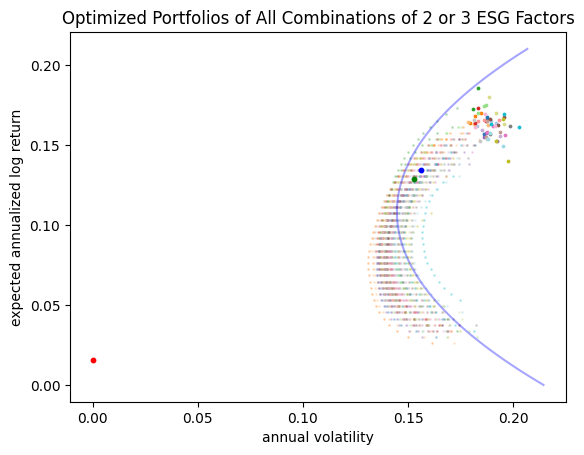

In [141]:
'''
story part 1:
stability of ESG factors
just scatter plot of optimized portfolios compared to SP500 curve
'''

fig2 = plt.figure()

for idx, (combination, points) in enumerate(markowitz_results):
    
    print(combination, len(points[0]), len(points[1]))
    
    if(len(points[0]) > 5):
    
        #volatilities stored in points[0], returns stored in points[1]
        (tangent_return, tangent_volatility) = tangent_portfolio(points[1], points[0])
        
        if(tangent_return <= 0.21):
            plt.scatter(tangent_volatility, tangent_return, s=3, color=colors[idx], alpha=1, label=combination)
        
        plt.scatter(points[0], points[1], s=1, color = colors[idx], alpha = 0.25)
    
    #plt.plot([tangent_line(xi, tangent_return, tangent_volatility) for xi in x], x)


x = np.linspace(start=0.0, stop = 0.21, num = 100)

plt.plot([sp_best_fit(xi) for xi in x], x, color = 'blue', alpha = 0.35)

plt.scatter(0, annual_risk_free_rate, s=10, color='red')
plt.scatter(SP500_annual_volatility, SP500_annual_return, s=10, color='blue')
plt.scatter(SPESG_annual_volatility, SPESG_annual_return, s=10, color='green')

plt.xlabel('annual volatility')
plt.ylabel('expected annualized log return')

plt.title(f"Optimized Portfolios of All Combinations of 2 or 3 ESG Factors")
#plt.legend()
plt.show()

#point out distance tangency points 
# to efficient frontier

0
42
20


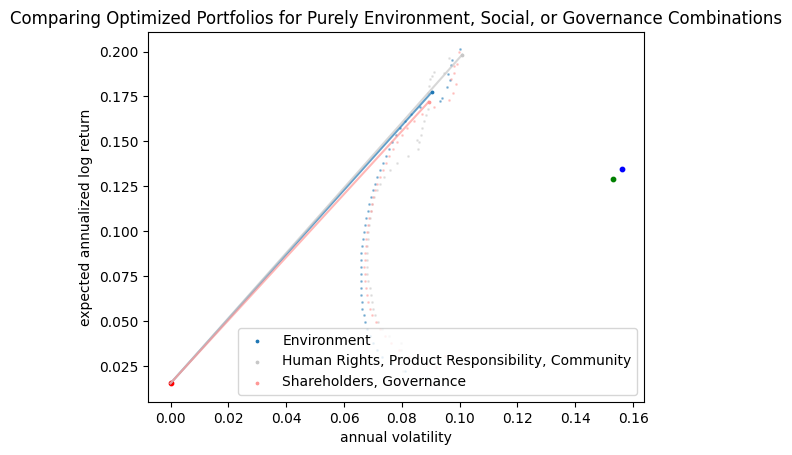

In [ ]:
'''
story part 2:
compare only environmental vs only social vs only governance factors

workforce is also social but we're only considering combinations of up to 3 factors
factors = ['environment', 'human_rights','workforce','product_responsibility',
           'shareholders','community','governance']
'''
fig3 = plt.figure()

for combination in [('environment'), 
                    ('human_rights','product_responsibility', 'community'), 
                    ('shareholders','governance')]:
    
    idx = combinations.index(combination)
    print(idx)
    
    #results format: (combination, (volatilities, results))
    returns = markowitz_results[idx][1][1]
    volatilities = markowitz_results[idx][1][0]
    
    (tangent_return, tangent_volatility, specific_best_fit) = tangent_portfolio(returns, volatilities, return_best_fit=True)
    
    color = colors[idx]
    
    if(2 <= len(combination) <= 3):
        label = ", ".join(word.replace("_", " ").title() for word in combination)
    else:
        label = combination.title()
    
    
    plt.scatter(tangent_volatility, tangent_return, s=3, color=color, alpha=1, label=label)
    plt.scatter(volatilities, returns, s=1, color = color, alpha = 0.4)
    
    y = np.linspace(start=annual_risk_free_rate, stop = tangent_return, num = 100)
    
    plt.plot([tangent_line(yi, tangent_return, tangent_volatility) for yi in y], y, color = color, alpha = 0.7)
    #plt.plot([specific_best_fit(yi) for yi in y], y, color = color, alpha = 0.7)

#y = np.linspace(start=annual_risk_free_rate, stop = 0.21, num = 100)
#plt.plot([sp_best_fit(yi) for yi in y], y, color = 'blue', alpha = 0.35)

plt.scatter(0, annual_risk_free_rate, s=10, color='red')
plt.scatter(SP500_annual_volatility, SP500_annual_return, s=10, color='blue')
plt.scatter(SPESG_annual_volatility, SPESG_annual_return, s=10, color='green')

plt.xlabel('annual volatility')
plt.ylabel('expected annualized log return')

plt.title(f"Comparing Optimized Portfolios for Purely Environment, Social, or Governance Combinations")
plt.legend()
plt.show()

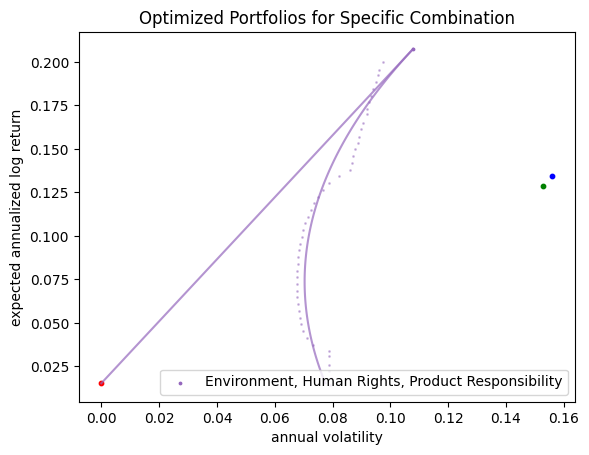

In [ ]:
'''
story part 3:
focus on just one combination of factors
'''

fig4 = plt.figure()

specific_combination = ('environment', 'human_rights', 'product_responsibility')

idx = combinations.index(specific_combination)
    
#results format: (combination, (volatilities, results))
returns = markowitz_results[idx][1][1]
volatilities = markowitz_results[idx][1][0]
    
(tangent_return, tangent_volatility, specific_best_fit) = tangent_portfolio(returns, volatilities, return_best_fit=True)
    
color = colors[idx]
    
if(2 <= len(specific_combination) <= 3):
    label = ", ".join(word.replace("_", " ").title() for word in specific_combination)
else:
    label = specific_combination.title()
    
    
plt.scatter(tangent_volatility, tangent_return, s=3, color=color, alpha=1, label=label)
plt.scatter(volatilities, returns, s=1, color = color, alpha = 0.4)
    
y = np.linspace(start=annual_risk_free_rate, stop = tangent_return, num = 100)

plt.plot([tangent_line(yi, tangent_return, tangent_volatility) for yi in y], y, color = color, alpha = 0.7)
plt.plot([specific_best_fit(yi) for yi in y], y, color = color, alpha = 0.7)

#plt.plot([sp_best_fit(yi) for yi in y], y, color = 'blue', alpha = 0.35)

plt.scatter(0, annual_risk_free_rate, s=10, color='red')
plt.scatter(SP500_annual_volatility, SP500_annual_return, s=10, color='blue')
plt.scatter(SPESG_annual_volatility, SPESG_annual_return, s=10, color='green')

plt.xlabel('annual volatility')
plt.ylabel('expected annualized log return')

plt.title(f"Optimized Portfolios for Specific Combination")
plt.legend()
plt.show()

#show equal weighting sp500 benchmark
#comparisons for dashboard:

#equal weighted using esg factors
#market weighted SP
#equal weighted sp

#easier to implement equal weight trade vs market cap

('environment', 'human_rights', 'product_responsibility') 59
target_return                                                 0.000686
annual_return                                                 0.150021
annual_volatility                                             0.090058
weights              [0.03639924512060135, 0.036377427742127724, 0....
diversification                                                 0.8543
Name: 41, dtype: object
103.52891125855983


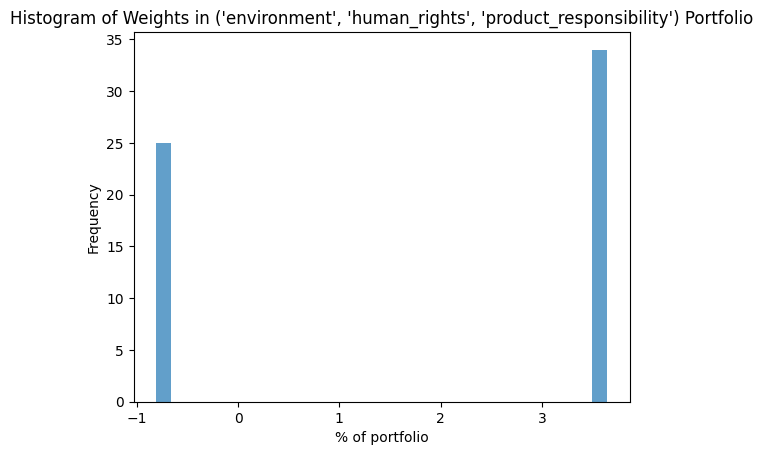

In [ ]:
'''
story part 4:
compare tickers in that combination vs voo
'''
#compare bar graphs of sp500 weights vs esg weights
#show top 10 tickers by esg weight vs which are top 10 in voo

user_preferences_dict = {}
for factor in factors:
    if factor in specific_combination:
        user_preferences_dict[factor] = 10
    else:
        user_preferences_dict[factor] = np.random.choice([0, 5])

tickers = stock_filter.filter_stocks(user_preferences_dict, tickers_only=True)

# keep tickers for which we have price data
tickers = list(set(tickers) & set(unique_tickers))
    
print(specific_combination, len(tickers))

# select relevant mean return and covariance data    
# mean log annual return is in first row, divide by 252 to get daily return

specific_combination_optimal_portfolios = markowitz_optimization.calculate_optimal_portfolios(opt.matrix((all_performance_summaries[tickers].iloc[0])/252),
                                                                             opt.matrix(adjusted_cov_matrix.loc[tickers, tickers].to_numpy()),
                                                                             target_returns,
                                                                             annual_risk_free_rate,
                                                                             bounds=[0.25/n, 4.0/n])

specific_combination_optimal_portfolios = specific_combination_optimal_portfolios.sort_values(by='annual_return',
                                                                                              ascending= True)

closest_portfolio = specific_combination_optimal_portfolios.loc[(specific_combination_optimal_portfolios['annual_return'] - target_return).abs().idxmin()]

#TODO figure out why some weights are negative?
closest_portfolio_weights = closest_portfolio['weights'] * 100

print(closest_portfolio)

#print(sorted(closest_portfolio_weights))

print(sum(closest_portfolio_weights))

plt.hist(closest_portfolio_weights, bins=30, alpha=0.7)
plt.xlabel('% of portfolio')
plt.ylabel('Frequency')
plt.title(f'Histogram of Weights in {specific_combination} Portfolio')
plt.show()

In [ ]:

# given that optimal_portfolios is already sorted by return, find the row closest to ret_t
'''
ideal_portfolio = optimal_portfolios.loc[(optimal_portfolios['annual_return'] - ret_t).abs().idxmin()][['annual_return', 'annual_volatility', 'weights']]

ideal_portfolio_df = pd.DataFrame({
    'annual_return': [ideal_portfolio['annual_return']] + [None] * (n - 1),
    'annual_volatility': [ideal_portfolio['annual_volatility']] + [None] * (n - 1),
    'weights': ideal_portfolio['weights']
})

ideal_portfolio_df.to_csv("ideal_portfolio.csv", index=False)
'''

'\nideal_portfolio = optimal_portfolios.loc[(optimal_portfolios[\'annual_return\'] - ret_t).abs().idxmin()][[\'annual_return\', \'annual_volatility\', \'weights\']]\n\nideal_portfolio_df = pd.DataFrame({\n    \'annual_return\': [ideal_portfolio[\'annual_return\']] + [None] * (n - 1),\n    \'annual_volatility\': [ideal_portfolio[\'annual_volatility\']] + [None] * (n - 1),\n    \'weights\': ideal_portfolio[\'weights\']\n})\n\nideal_portfolio_df.to_csv("ideal_portfolio.csv", index=False)\n'

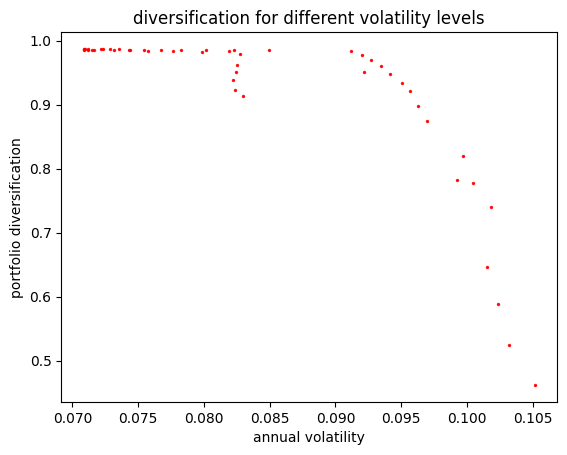

In [ ]:
plt.scatter(optimal_portfolios['annual_volatility'],
            optimal_portfolios['diversification'], s=2, c='red', alpha=0.9)
plt.xlabel('annual volatility')
plt.ylabel('portfolio diversification')
plt.title('diversification for different volatility levels')
plt.show()